# The Duffing oscillator

In [32]:
import numpy as np
from scipy.linalg import eig
import matplotlib.pyplot as plt

In [33]:
#Define Jacobian matrix E= dF(0)/dz at origin
alpha = 1
beta = -1
delta = 0.5
E = np.array([[0,alpha],[-beta,-delta]])

e,evecL,evecR = eig(E,left=True)
# eigenvalues
eval1 = e[0].real
eval2 = e[1].real
# eigenvectors
w1 = evecL[:,0]
w2 = evecL[:,1]

In [46]:
print(eval1)
print(eval2)

0.7807764064044151
-1.2807764064044151


In [34]:
#Define (z_1,z_2) grid

npoints = 60
x_grid = np.linspace(-2, 2, npoints)
y_grid = np.linspace(-2, 2, npoints)

X,Y = np.meshgrid(x_grid,y_grid)
XY = np.zeros((npoints**2,2))

k = 0
for i in range(npoints):
    for j in range(npoints):
        XY[k,:] = np.array([X[i,j],Y[i,j]])
        k = k+1

In [35]:
#Define functions F and G
def F(x):
    value1 = x[:,1]
    value2 = -delta * x[:,1] - x[:,0] * (beta + alpha * x[:,0]**2)
    return np.array([value1, value2]).T

# Define the function g using autograd's numpy (jnp)
def G(x):
    value = np.zeros((len(x),2))
    for i in range(len(x)):
        value[i,:] = np.dot(E, x[i,:])
    value = F(x)-value
    return value

In [36]:
# copute F and G at mesh grids
F_val = F(XY)
G_val = G(XY)

#### Eigenfunction $\phi_{\lambda_1}$

In [37]:
phi1_hat = np.zeros((npoints,npoints))
T = 20
# number of features
N = 1000
# scaling parameter
gamma = 0.000001

# right-hand side
y0 = np.zeros((3,1))
y1 = np.zeros((npoints**2,1))
for i in range(npoints**2):
    y1[i] = -G_val[i,:] @ w1
y = np.row_stack((y0,y1))

for t in range(T):
    # Generate random features
    # random feature matrix
    Omega = np.random.normal(0, np.sqrt(2*gamma), size=(2,N) )
    # random bias
    random_bias = np.random.uniform(-np.pi, np.pi, size=(N,))
    # temp matrix
    A_0 = np.cos(random_bias)
    B_0 = np.sin(random_bias)
    # generate amtrix A
    A = np.zeros((npoints**2+3,N))
    A[0,:] = A_0                   # h(0) = 0
    A[1:3,:] = B_0 * Omega         # h'(0) = 0
    # linear pde
    A[3:,:] = - F_val @ Omega * np.sin(XY @ Omega + random_bias) - eval1 * np.cos(XY @ Omega + random_bias) 

    
    # solve optimization problem
    c = np.linalg.pinv(A) @ y
    # estimate non-linear function h at mesh grids
    K = np.cos(XY @ Omega + random_bias)
    y_test = K@c

    # estimate eigenfunction
    phi1_hat = phi1_hat + y_test.reshape(npoints,npoints) + w1[0] * X + w1[1] * Y
    
phi_hat = phi1_hat / T

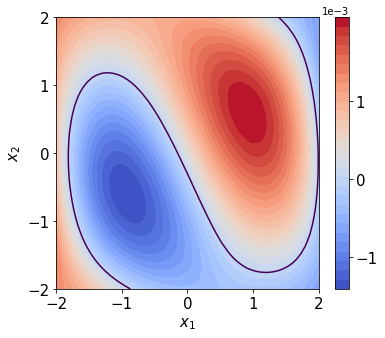

In [48]:
min_val = np.min(phi_hat) 
max_val = np.max(phi_hat)

# visualization
plt.subplots(figsize=(20,5))
plt.subplot(1,3,1)
im = plt.contourf(X,Y,phi_hat,levels=np.linspace(min_val,max_val,30), cmap="coolwarm")
cbar = plt.colorbar(im, ticks=[-0.001,0,0.001])
cbar.ax.tick_params(labelsize=15)
cbar.formatter.set_powerlimits((0, 0))
plt.contour(X,Y,phi_hat, levels=[0])

plt.xlabel(r'$x_1$', fontsize=15)
plt.ylabel(r'$x_2$',fontsize=15)
plt.xticks([-2,-1,0,1,2],fontsize=15)
plt.yticks([-2,-1,0,1,2], fontsize=15)
plt.savefig('eig.pdf', bbox_inches = 'tight')

#### Eigenfunction $\phi_{\lambda_2}$

In [23]:
# Generate random features
# number of features
N = 1500
# scaling parameter
gamma = 1e-6
# random feature matrix
Omega = np.random.normal(0, np.sqrt(2*gamma), size=(2,N) )
# random bias
random_bias = np.random.uniform(-np.pi, np.pi, size=(N,))
# temp matrix
A_0 = np.cos(random_bias)
B_0 = np.sin(random_bias)
# generate amtrix A
A = np.zeros((npoints**2+3,N))
A[0,:] = A_0                   # h(0) = 0
A[1:3,:] = B_0 * Omega         # h'(0) = 0
# linear pde
A[3:,:] = - F_val @ Omega * np.sin(XY @ Omega + random_bias) - eval2 * np.cos(XY @ Omega + random_bias) 

# right-hand side
y0 = np.zeros((3,1))
y1 = np.zeros((npoints**2,1))
for i in range(npoints**2):
    y1[i] = -G_val[i,:] @ w2
y = np.row_stack((y0,y1))

# solve optimization problem
c = np.linalg.pinv(A) @ y
# estimate non-linear function h at mesh grids
K = np.cos(XY @ Omega + random_bias)
y_test = K@c

# estimate eigenfunction
phi2_hat = y_test.reshape(npoints,npoints) + w2[0] * X + w2[1] * Y
# compute true eigenfucntion
#phi2 = phi_2(XY).reshape(npoints,npoints)

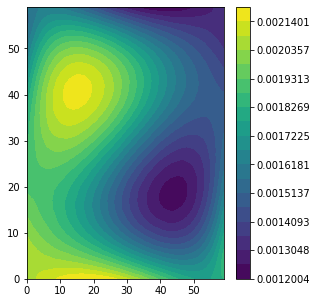

In [24]:
min_val = np.min(phi2_hat)
max_val = np.max(phi2_hat)

# visualization
plt.subplots(figsize=(15,5))
plt.subplot(1,3,1)
im = plt.contourf(phi2_hat, levels=np.linspace(min_val,max_val,20))
plt.colorbar(im)

#plt.subplot(1,3,2)
#im = plt.contourf(phi2, levels=np.linspace(-5,1,20))
#plt.colorbar(im)

#plt.subplot(1,3,3)
#im = plt.imshow(abs(phi2 - phi2_hat))
#plt.colorbar(im)